# Load Modules

In [91]:
# Modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, auc, classification_report, dcg_score, f1_score, precision_recall_curve,\
                             precision_score, recall_score, roc_auc_score, roc_curve)
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import pycaret
import pandas_profiling
import matplotlib.pyplot as plt
import itertools

import pickle
import joblib
import math
import os

from pygam import LogisticGAM, s, f
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Eval Functions 
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # fi to dataframe
#     df = pd.DataFrame(data=[model.feature_importances_, model.feature_name_], index=['importance','feature']).T
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

def classification_result(df, y_true, y_pred):
    conditionlist = [
        (df['y_true']==1) & (df['y_pred']==1),
        (df['y_true']==0) & (df['y_pred']==0),
        (df['y_true']==0) & (df['y_pred']==1),
        (df['y_true']==1) & (df['y_pred']==0)]
    
    choicelist = ['TP', 'TN', 'FP', 'FN']
    
    df['class'] = np.select(conditionlist, choicelist, default='Not Specified')
    
    return df

In [92]:
import utils_jh

In [3]:
print(os.listdir('../../../data/santander/raw/'))

['test.csv', 'original_train.pickle', 'train.csv', 'original_test.pickle']


# Load Data

In [4]:
# path = '../Digitallab_Project/what_if/data/santander'
path = '../../../data/santander/raw/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
seed=777

In [5]:
df_train.sample(3)

ID_code  target    var_0   var_1    var_2   var_3    var_4  \
13545    train_13545       0   9.8184  1.1793   7.5984  8.2169  10.6336   
144823  train_144823       0   9.1629 -6.7484  11.1156  7.1689  11.1525   
158616  train_158616       0  12.0625 -6.8557   7.0221  5.2779  10.6186   

          var_5   var_6    var_7  ...  var_190  var_191  var_192  var_193  \
13545  -12.4989  4.9437  13.0358  ...   0.3382   5.9993   3.5082  -0.1019   
144823  -5.2405  5.3216  19.3275  ...  -0.1312   0.4617   2.5552   2.8452   
158616  -2.8177  6.5237  16.3616  ...   6.3074   5.8263   3.4155   1.4304   

        var_194  var_195  var_196  var_197  var_198  var_199  
13545   19.4588   1.0046  -7.7503  10.4842  15.4634 -14.9370  
144823  19.4825   0.2151  12.4056   7.7766  15.1749  -2.1039  
158616  19.5531   0.9956  -3.2842   9.4040  10.2423  17.7424  

[3 rows x 202 columns]

In [6]:
df_train.shape

(200000, 202)

# EBM Modeling

## Prepare dataset for modeling

In [5]:
X = df_train.drop(['ID_code', 'target'], axis=1)
y = df_train['target']

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (140000, 200) 	 test :  (60000, 200)


## Train

In [7]:
# Load Modules for EBM
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
from interpret.data import ClassHistogram

In [9]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

KeyboardInterrupt: 

In [8]:
ebm = joblib.load('01_05_ebm_org_data.pkl')

## Predict

In [183]:
df_rslt_tr = utils_jh.classification_result(ebm, X_train, y_train)
df_rslt_vld = utils_jh.classification_result(ebm, X_valid, y_valid)

# EDA

In [184]:
df_rslt_vld = df_rslt_vld[['y_proba_1', 'y_true', 'y_pred', 'class']]

In [185]:
labels = ["{0}-{1}".format(i/10, (i + 1)/10) for i in range(0, 10)]
df_rslt_vld["group"] = pd.cut(df_rslt_vld.y_proba_1, bins=10, right=False, labels=labels)
df_rslt_vld.tail(3)

y_proba_1  y_true  y_pred class    group
59997   0.053983       0       0    TN  0.0-0.1
59998   0.289528       1       0    FN  0.2-0.3
59999   0.353044       0       0    TN  0.3-0.4

In [186]:
df_vld_group = pd.DataFrame(df_rslt_vld.groupby('group').count()['y_proba_1'])
df_vld_group = df_vld_group.rename({'y_proba_1':'count'}, axis=1).reset_index()
df_vld_group['percent'] = df_vld_group['count']/df_vld_group['count'].sum()
df_vld_group

group  count   percent
0  0.0-0.1  45133  0.752217
1  0.1-0.2   6697  0.111617
2  0.2-0.3   2903  0.048383
3  0.3-0.4   1598  0.026633
4  0.4-0.5    984  0.016400
5  0.5-0.6    768  0.012800
6  0.6-0.7    595  0.009917
7  0.7-0.8    506  0.008433
8  0.8-0.9    453  0.007550
9  0.9-1.0    363  0.006050

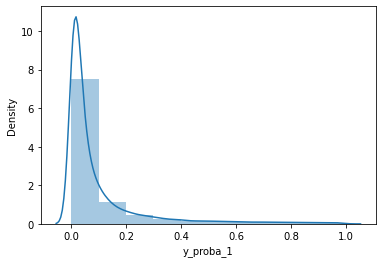

In [187]:
sns.distplot(df_rslt_vld['y_proba_1'], bins=10)
plt.show()

In [188]:
df_rslt_vld = pd.concat([pd.DataFrame(data=X_valid.index,columns=['index']),
                         df_rslt_vld], 
                        axis=1)
df_rslt_vld.sample(3)

index  y_proba_1  y_true  y_pred class    group
35683  146752   0.015215       0       0    TN  0.0-0.1
26984   25696   0.020943       0       0    TN  0.0-0.1
19400  107054   0.376908       0       0    TN  0.3-0.4

In [189]:
df_rslt_vld[df_rslt_vld['group']=='0.4-0.5']

index  y_proba_1  y_true  y_pred class    group
30     142576   0.415009       0       0    TN  0.4-0.5
132    109106   0.418301       1       0    FN  0.4-0.5
180    107899   0.455435       1       0    FN  0.4-0.5
235    189887   0.418708       0       0    TN  0.4-0.5
374     23444   0.454629       0       0    TN  0.4-0.5
...       ...        ...     ...     ...   ...      ...
59576  153134   0.472974       0       0    TN  0.4-0.5
59677  166784   0.441138       0       0    TN  0.4-0.5
59791   96685   0.494144       1       0    FN  0.4-0.5
59955  185285   0.457513       1       0    FN  0.4-0.5
59962   22056   0.457387       0       0    TN  0.4-0.5

[984 rows x 6 columns]

In [273]:
idx_group_1_2 = df_rslt_vld[df_rslt_vld['group']=='0.1-0.2']['index'].values
idx_group_4_5 = df_rslt_vld[df_rslt_vld['group']=='0.4-0.5']['index'].values
idx_group_5_6 = df_rslt_vld[df_rslt_vld['group']=='0.5-0.6']['index'].values

# Counterfactuals - DiCE

## Instance with 0.4-0.5 probability

In [12]:
# pip install dice_ml

     |████████████████████████████████| 231 kB 1.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ebm = joblib.load('02_01_ebm_model_w_raw_data.pkl')

In [174]:
# Counterfactual 연산 시 인터랙션 Term 포함하면 학습이 불가능해서 배제해야함
ebm = ExplainableBoostingClassifier(interactions=0)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['var_0', 'var_1', 'var_2', 'var_3',
                                             'var_4', 'var_5', 'var_6', 'var_7',
                                             'var_8', 'var_9', 'var_10',
                                             'var_11', 'var_12', 'var_13',
                                             'var_14', 'var_15', 'var_16',
                                             'var_17', 'var_18', 'var_19',
                                             'var_20', 'var_21', 'var_22',
                                             'var_23', 'var_24', 'var_25',
                                             'var_26', 'var_27', 'var_28',
                                             'var_29', ...],
                              feature_types=['continuous', 'continuous'...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                 

In [180]:
joblib.dump(ebm, '02_03_ebm_model_no_interactions.pkl')

['02_03_ebm_model_no_interactions.pkl']

In [181]:
import dice_ml

# Dataset for training an ML model
d = dice_ml.Data(dataframe=df_train.iloc[:,1:],continuous_features=X_train.columns.tolist(), outcome_name='target')
# Pre-trained ML model
m = dice_ml.Model(model=ebm, backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d,m)

In [262]:
# 0.4 ~ 0.5의 probability를 가지는 instance중 첫번째를 query instance로 .. 
X_valid[X_valid.index == idx_group_4_5[0]]

var_0  var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
142576  7.2183 -1.553  10.6706  8.6826  10.2592 -9.1374  4.7995  13.5157   

        var_8   var_9  ...  var_190  var_191  var_192  var_193  var_194  \
142576  6.822  8.1468  ...  -5.3957   8.9595   0.9822   4.0618   18.422   

        var_195  var_196  var_197  var_198  var_199  
142576   0.8699   3.0251   6.9229  12.3385  14.4817  

[1 rows x 200 columns]

In [263]:
# Generate Counterfactuals 
e1 = exp.generate_counterfactuals(X_valid[X_valid.index == idx_group_4_5[0]], 
                                  total_CFs=10,
                                  desired_class="opposite",
                                  stopping_threshold=0.5,                              
                                  random_seed=seed)
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:32<00:00, 32.79s/it]

Query instance (original outcome : 0)


var_0  var_1    var_2   var_3    var_4   var_5   var_6    var_7  var_8  \
0  7.2183 -1.553  10.6706  8.6826  10.2592 -9.1374  4.7995  13.5157  6.822   

    var_9  ...  var_191  var_192  var_193  var_194  var_195  var_196  var_197  \
0  8.1468  ...   8.9595   0.9822   4.0618   18.422   0.8699   3.0251   6.9229   

   var_198  var_199  target  
0  12.3385  14.4817       0  

[1 rows x 201 columns]


Diverse Counterfactual set (new outcome: 1.0)


var_0   var_1 var_2 var_3 var_4 var_5   var_6 var_7 var_8   var_9  ...  \
0     -       -     -     -     -     -       -     -     -       -  ...   
1     -       -     -     -     -     -       -     -     -       -  ...   
2     -       -     -     -     -     -       -     -     -       -  ...   
3     -       -     -     -     -     -       -     -     -       -  ...   
4     -       -     -     -     -     -       -     -     -       -  ...   
5     -       -     -     -     -     -  3.5909     -     -       -  ...   
6     -       -     -     -     -     -       -     -     -       -  ...   
7     -       -     -     -     -     -       -     -     -       -  ...   
8     -  9.0042     -     -     -     -       -     -     -       -  ...   
9     -       -     -     -     -     -       -     -     -  5.3889  ...   

  var_191 var_192 var_193 var_194 var_195 var_196 var_197 var_198 var_199  \
0       -       -       -       -       -       -       -       -       -   
1       -       -       -       -       -       -       -       -       -   
2       -       -       -       -       -       -       -       -       -   
3       -       -       -       -       -       -       -       -       -   
4       -       -       -       -       -       -       -       -       -   
5       -       -       -       -       -       -       -       -       -   
6       -       -       -  9.9551       -       -       -       -       -   
7       -       -       -       -       -       -       -       -       -   
8       -       -       -       -       -       -       -       -       -   
9       -       -       -       -       -       -       -       -       -   

  target  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
5    1.0  
6    1.0  
7    1.0  
8    1.0  
9    1.0  

[10 rows x 201 columns]

In [265]:
# 최종 cfs 배열 반환
X_cfs = exp.final_cfs
X_cfs

array([[ 7.2183, -1.553 , 10.6706, ...,  6.9229, 12.3385, 14.4817],
       [ 7.2183, -1.553 , 10.6706, ...,  6.9229, 12.3385, 14.4817],
       [ 7.2183, -1.553 , 10.6706, ...,  6.9229, 12.3385, 14.4817],
       ...,
       [ 7.2183, -1.553 , 10.6706, ...,  6.9229, 12.3385, 14.4817],
       [ 7.2183,  9.0042, 10.6706, ...,  6.9229, 12.3385, 14.4817],
       [ 7.2183, -1.553 , 10.6706, ...,  6.9229, 12.3385, 14.4817]])

In [266]:
# CF로 Predict결과보기 
ebm.predict_proba(X_cfs)

array([[0.40226627, 0.59773373],
       [0.40673339, 0.59326661],
       [0.48473605, 0.51526395],
       [0.48748641, 0.51251359],
       [0.47808217, 0.52191783],
       [0.49700202, 0.50299798],
       [0.4648323 , 0.5351677 ],
       [0.387598  , 0.612402  ],
       [0.43150609, 0.56849391],
       [0.46522772, 0.53477228]])

In [272]:
# Instance와 CF 간 비교를 위한 Dataframe 생성
df_compare = pd.concat([X_valid[X_valid.index == idx_group_4_5[0]], 
                        pd.DataFrame(X_cfs, columns=X_valid.columns, 
                                    index=('cf{}'.format(i) for i in range(0,10)))], 
                       axis=0).T
df_compare.head(3)

142576      cf0      cf1      cf2      cf3      cf4      cf5      cf6  \
var_0   7.2183   7.2183   7.2183   7.2183   7.2183   7.2183   7.2183   7.2183   
var_1  -1.5530  -1.5530  -1.5530  -1.5530  -1.5530  -1.5530  -1.5530  -1.5530   
var_2  10.6706  10.6706  10.6706  10.6706  10.6706  10.6706  10.6706  10.6706   

           cf7      cf8      cf9  
var_0   7.2183   7.2183   7.2183  
var_1  -1.5530   9.0042  -1.5530  
var_2  10.6706  10.6706  10.6706

In [251]:
# from tabulate import tabulate
# print(tabulate(df, headers='keys', tablefmt='psql'))

In [271]:
# Instance와 CF 간 비교 차이나는 변수 비교
for i in range(0,10):
    
    instance_index = df_compare.columns[0]
    df_delta = df_compare[df_compare[instance_index]-df_compare['cf{}'.format(i)] !=0]
    
    print('[ vs cf{} ]'.format(i))
    print('* {} features need to be changed : {}'
          .format(df_delta.count()[instance_index],df_delta[[instance_index,'cf{}'.format(i)]].index.tolist()))

    print(tabulate(df_delta[[instance_index,'cf{}'.format(i)]], headers='keys', tablefmt='psql'))
    print('\n')

[ vs cf0 ]
* 1 features need to be changed : ['var_110']
+---------+----------+---------+
|         |   142576 |     cf0 |
|---------+----------+---------|
| var_110 |  -1.1574 | 16.7843 |
+---------+----------+---------+


[ vs cf1 ]
* 2 features need to be changed : ['var_73', 'var_92']
+--------+----------+--------+
|        |   142576 |    cf1 |
|--------+----------+--------|
| var_73 |   7.0096 | 3.5759 |
| var_92 |  14.1    | 2.16   |
+--------+----------+--------+


[ vs cf2 ]
* 1 features need to be changed : ['var_60']
+--------+----------+--------+
|        |   142576 |    cf2 |
|--------+----------+--------|
| var_60 |     8.64 | 24.013 |
+--------+----------+--------+


[ vs cf3 ]
* 2 features need to be changed : ['var_14', 'var_166']
+---------+----------+--------+
|         |   142576 |    cf3 |
|---------+----------+--------|
| var_14  |   8.5587 | 4.0315 |
| var_166 |   2.9883 | 2.3648 |
+---------+----------+--------+


[ vs cf4 ]
* 1 features need to be changed : ['v

## Instance with 0.1-0.2 probability

In [274]:
# 0.1 ~ 0.2의 probability를 가지는 instance중 첫번째를 query instance로 .. 
X_valid[X_valid.index == idx_group_1_2[0]]

var_0   var_1    var_2   var_3    var_4  var_5   var_6    var_7  \
100237  13.5513 -2.6086  11.1205  5.9994  10.0885 -5.718  7.6887  17.9109   

         var_8   var_9  ...  var_190  var_191  var_192  var_193  var_194  \
100237 -4.3369  8.0232  ...   9.1231     2.35   3.5814  -0.8796  14.0991   

        var_195  var_196  var_197  var_198  var_199  
100237   0.8537   4.7012   7.3468  16.3235  -4.5827  

[1 rows x 200 columns]

In [292]:
# Generate Counterfactuals 
e2 = exp.generate_counterfactuals(X_valid[X_valid.index == idx_group_1_2[0]], 
                                  total_CFs=10,
                                  desired_class="opposite",
                                  stopping_threshold=0.5,                              
                                  random_seed=seed)
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:32<00:00, 32.81s/it]

Query instance (original outcome : 0)


var_0   var_1    var_2   var_3    var_4  var_5   var_6    var_7   var_8  \
0  13.5513 -2.6086  11.1205  5.9994  10.0885 -5.718  7.6887  17.9109 -4.3369   

    var_9  ...  var_191  var_192  var_193  var_194  var_195  var_196  var_197  \
0  8.0232  ...     2.35   3.5814  -0.8796  14.0991   0.8537   4.7012   7.3468   

   var_198  var_199  target  
0  16.3235  -4.5827       0  

[1 rows x 201 columns]


Diverse Counterfactual set (new outcome: 1.0)


var_0 var_1 var_2 var_3 var_4 var_5 var_6 var_7   var_8 var_9  ...  \
0        -     -     -     -     -     -     -     -       -     -  ...   
1        -     -     -     -     -     -     -     -       -     -  ...   
2        -     -     -     -     -     -     -     -       -     -  ...   
3        -     -     -     -     -     -     -     -       -     -  ...   
4  18.3854     -     -     -     -     -     -     -       -     -  ...   
5        -     -     -     -     -     -     -     -       -     -  ...   
6        -     -     -     -     -     -     -     -       -     -  ...   
7        -     -     -     -     -     -     -     -       -     -  ...   
8        -     -     -     -     -     -     -     -  9.1431     -  ...   
9        -     -     -     -     -     -     -     -       -     -  ...   

  var_191 var_192  var_193 var_194 var_195 var_196 var_197 var_198 var_199  \
0       -       -        -       -       -       -       -       -       -   
1       -       -        -       -       -       -       -       -       -   
2       -       -        -       -       -       -       -       -       -   
3       -       -  15.4159       -       -       -       -       -       -   
4       -       -        -       -       -       -       -       -       -   
5       -       -        -       -       -       -       -       -       -   
6       -       -        -       -       -       -       -       -       -   
7       -       -        -       -       -       -       -   6.583       -   
8       -       -        -       -       -       -       -       -       -   
9       -       -        -       -       -       -       -       -       -   

  target  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
5    1.0  
6    1.0  
7    1.0  
8    1.0  
9    1.0  

[10 rows x 201 columns]

In [293]:
X_cfs_2=exp.final_cfs

In [294]:
ebm.predict_proba(exp.final_cfs)

array([[0.42141125, 0.57858875],
       [0.47226267, 0.52773733],
       [0.43942142, 0.56057858],
       [0.41161417, 0.58838583],
       [0.4357561 , 0.5642439 ],
       [0.45048059, 0.54951941],
       [0.47050463, 0.52949537],
       [0.38111172, 0.61888828],
       [0.47957021, 0.52042979],
       [0.47697029, 0.52302971]])

In [295]:
# Instance와 CF 간 비교를 위한 Dataframe 생성
df_compare_2 = pd.concat([X_valid[X_valid.index == idx_group_1_2[0]], 
                        pd.DataFrame(X_cfs_2, columns=X_valid.columns, 
                                    index=('cf{}'.format(i) for i in range(0,10)))], 
                       axis=0).T
df_compare_2.head(3)

100237      cf0      cf1      cf2      cf3      cf4      cf5      cf6  \
var_0  13.5513  13.5513  13.5513  13.5513  13.5513  18.3854  13.5513  13.5513   
var_1  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086   
var_2  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205   

           cf7      cf8      cf9  
var_0  13.5513  13.5513  13.5513  
var_1  -2.6086  -2.6086  -2.6086  
var_2  11.1205  11.1205  11.1205

In [296]:
# Instance와 CF 간 비교 차이나는 변수 비교
for i in range(0,10):
    
    instance_index = df_compare_2.columns[0]
    df_delta = df_compare_2[df_compare_2[instance_index]-df_compare_2['cf{}'.format(i)] !=0]
    
    print('[ vs cf{} ]'.format(i))
    print('* {} features need to be changed : {}'
          .format(df_delta.count()[instance_index],df_delta[[instance_index,'cf{}'.format(i)]].index.tolist()))

    print(tabulate(df_delta[[instance_index,'cf{}'.format(i)]], headers='keys', tablefmt='psql'))
    print('\n')

[ vs cf0 ]
* 5 features need to be changed : ['var_81', 'var_88', 'var_98', 'var_115', 'var_188']
+---------+----------+---------+
|         |   100237 |     cf0 |
|---------+----------+---------|
| var_81  |  14.6421 |  8.804  |
| var_88  |   9.5149 |  2.6113 |
| var_98  |   1.5288 | -0.2037 |
| var_115 |  -0.2605 | -5.3861 |
| var_188 |  16.1041 |  6.363  |
+---------+----------+---------+


[ vs cf1 ]
* 5 features need to be changed : ['var_13', 'var_30', 'var_86', 'var_108', 'var_141']
+---------+----------+----------+
|         |   100237 |      cf1 |
|---------+----------+----------|
| var_13  |  11.7553 |  -1.7848 |
| var_30  | -11.741  | -27.2757 |
| var_86  |   3.2013 | -11.2446 |
| var_108 |  14.2392 |  13.8802 |
| var_141 |   3.5194 | -10.6308 |
+---------+----------+----------+


[ vs cf2 ]
* 4 features need to be changed : ['var_26', 'var_61', 'var_91', 'var_133']
+---------+----------+---------+
|         |   100237 |     cf2 |
|---------+----------+---------|
| var_26  |

## Change 'stopping_threshold' test

### stopping_threshold = 0.5 (Default)

In [297]:
# Generate Counterfactuals 
e3 = exp.generate_counterfactuals(X_valid[X_valid.index == idx_group_1_2[0]], 
                                  total_CFs=10,
                                  desired_class="opposite",
                                  stopping_threshold=0.5,                              
                                  random_seed=seed)
e3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:34<00:00, 34.63s/it]

Query instance (original outcome : 0)


var_0   var_1    var_2   var_3    var_4  var_5   var_6    var_7   var_8  \
0  13.5513 -2.6086  11.1205  5.9994  10.0885 -5.718  7.6887  17.9109 -4.3369   

    var_9  ...  var_191  var_192  var_193  var_194  var_195  var_196  var_197  \
0  8.0232  ...     2.35   3.5814  -0.8796  14.0991   0.8537   4.7012   7.3468   

   var_198  var_199  target  
0  16.3235  -4.5827       0  

[1 rows x 201 columns]


Diverse Counterfactual set (new outcome: 1.0)


var_0 var_1 var_2 var_3 var_4 var_5 var_6 var_7   var_8 var_9  ...  \
0        -     -     -     -     -     -     -     -       -     -  ...   
1        -     -     -     -     -     -     -     -       -     -  ...   
2        -     -     -     -     -     -     -     -       -     -  ...   
3        -     -     -     -     -     -     -     -       -     -  ...   
4  18.3854     -     -     -     -     -     -     -       -     -  ...   
5        -     -     -     -     -     -     -     -       -     -  ...   
6        -     -     -     -     -     -     -     -       -     -  ...   
7        -     -     -     -     -     -     -     -       -     -  ...   
8        -     -     -     -     -     -     -     -  9.1431     -  ...   
9        -     -     -     -     -     -     -     -       -     -  ...   

  var_191 var_192  var_193 var_194 var_195 var_196 var_197 var_198 var_199  \
0       -       -        -       -       -       -       -       -       -   
1       -       -        -       -       -       -       -       -       -   
2       -       -        -       -       -       -       -       -       -   
3       -       -  15.4159       -       -       -       -       -       -   
4       -       -        -       -       -       -       -       -       -   
5       -       -        -       -       -       -       -       -       -   
6       -       -        -       -       -       -       -       -       -   
7       -       -        -       -       -       -       -   6.583       -   
8       -       -        -       -       -       -       -       -       -   
9       -       -        -       -       -       -       -       -       -   

  target  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
5    1.0  
6    1.0  
7    1.0  
8    1.0  
9    1.0  

[10 rows x 201 columns]

In [300]:
X_cfs_3 = exp.final_cfs
X_cfs_3

array([[13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       ...,
       [13.5513, -2.6086, 11.1205, ...,  7.3468,  6.583 , -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827]])

In [299]:
# Instance와 CF 간 비교를 위한 Dataframe 생성
df_compare_3 = pd.concat([X_valid[X_valid.index == idx_group_1_2[0]], 
                        pd.DataFrame(X_cfs_3, columns=X_valid.columns, 
                                    index=('cf{}'.format(i) for i in range(0,10)))], 
                       axis=0).T
df_compare_3.head(3)

100237      cf0      cf1      cf2      cf3      cf4      cf5      cf6  \
var_0  13.5513  13.5513  13.5513  13.5513  13.5513  18.3854  13.5513  13.5513   
var_1  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086   
var_2  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205   

           cf7      cf8      cf9  
var_0  13.5513  13.5513  13.5513  
var_1  -2.6086  -2.6086  -2.6086  
var_2  11.1205  11.1205  11.1205

In [301]:
# Instance와 CF 간 비교 차이나는 변수 비교
for i in range(0,10):
    
    instance_index = df_compare_3.columns[0]
    df_delta = df_compare_3[df_compare_3[instance_index]-df_compare_3['cf{}'.format(i)] !=0]
    
    print('[ vs cf{} ]'.format(i))
    print('* {} features need to be changed : {}'
          .format(df_delta.count()[instance_index],df_delta[[instance_index,'cf{}'.format(i)]].index.tolist()))

    print(tabulate(df_delta[[instance_index,'cf{}'.format(i)]], headers='keys', tablefmt='psql'))
    print('\n')

[ vs cf0 ]
* 5 features need to be changed : ['var_81', 'var_88', 'var_98', 'var_115', 'var_188']
+---------+----------+---------+
|         |   100237 |     cf0 |
|---------+----------+---------|
| var_81  |  14.6421 |  8.804  |
| var_88  |   9.5149 |  2.6113 |
| var_98  |   1.5288 | -0.2037 |
| var_115 |  -0.2605 | -5.3861 |
| var_188 |  16.1041 |  6.363  |
+---------+----------+---------+


[ vs cf1 ]
* 5 features need to be changed : ['var_13', 'var_30', 'var_86', 'var_108', 'var_141']
+---------+----------+----------+
|         |   100237 |      cf1 |
|---------+----------+----------|
| var_13  |  11.7553 |  -1.7848 |
| var_30  | -11.741  | -27.2757 |
| var_86  |   3.2013 | -11.2446 |
| var_108 |  14.2392 |  13.8802 |
| var_141 |   3.5194 | -10.6308 |
+---------+----------+----------+


[ vs cf2 ]
* 4 features need to be changed : ['var_26', 'var_61', 'var_91', 'var_133']
+---------+----------+---------+
|         |   100237 |     cf2 |
|---------+----------+---------|
| var_26  |

### stopping_threshold = 0.2

In [302]:
# Generate Counterfactuals 
e3_2 = exp.generate_counterfactuals(X_valid[X_valid.index == idx_group_1_2[0]], 
                                  total_CFs=10,
                                  desired_class="opposite",
                                  stopping_threshold=0.2,                              
                                  random_seed=seed)
e3_2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:34<00:00, 34.97s/it]

Query instance (original outcome : 0)


var_0   var_1    var_2   var_3    var_4  var_5   var_6    var_7   var_8  \
0  13.5513 -2.6086  11.1205  5.9994  10.0885 -5.718  7.6887  17.9109 -4.3369   

    var_9  ...  var_191  var_192  var_193  var_194  var_195  var_196  var_197  \
0  8.0232  ...     2.35   3.5814  -0.8796  14.0991   0.8537   4.7012   7.3468   

   var_198  var_199  target  
0  16.3235  -4.5827       0  

[1 rows x 201 columns]


Diverse Counterfactual set (new outcome: 1.0)


var_0 var_1    var_2 var_3    var_4 var_5 var_6 var_7   var_8 var_9  ...  \
0        -     -        -     -        -     -     -     -       -     -  ...   
1        -     -        -     -        -     -     -     -       -     -  ...   
2        -     -        -     -        -     -     -     -       -     -  ...   
3  20.1211     -        -     -        -     -     -     -       -     -  ...   
4        -     -        -     -        -     -     -     -       -     -  ...   
5        -     -  18.8698     -        -     -     -     -       -     -  ...   
6        -     -  18.8698     -        -     -     -     -       -     -  ...   
7        -     -        -     -  16.5593     -     -     -       -     -  ...   
8        -     -        -     -  16.5593     -     -     -       -     -  ...   
9        -     -        -     -        -     -     -     -  9.1431     -  ...   

   var_191 var_192  var_193 var_194 var_195 var_196 var_197 var_198 var_199  \
0        -       -        -       -       -       -       -       -       -   
1        -       -        -       -       -       -       -       -       -   
2  16.5288       -        -       -       -       -       -       -       -   
3        -       -        -       -       -       -       -       -       -   
4        -       -  15.4159       -       -       -       -       -       -   
5        -       -        -       -       -       -       -       -       -   
6        -       -        -       -       -       -       -       -       -   
7  16.5288       -        -       -       -       -       -       -       -   
8  16.5288       -        -       -       -       -       -       -       -   
9        -       -        -       -       -       -       -       -       -   

  target  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
5    1.0  
6    1.0  
7    1.0  
8    1.0  
9    1.0  

[10 rows x 201 columns]

In [303]:
X_cfs_3_2 = exp.final_cfs
X_cfs_3_2

array([[13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       ...,
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827]])

In [304]:
# Instance와 CF 간 비교를 위한 Dataframe 생성
df_compare_3_2 = pd.concat([X_valid[X_valid.index == idx_group_1_2[0]], 
                        pd.DataFrame(X_cfs_3_2, columns=X_valid.columns, 
                                    index=('cf{}'.format(i) for i in range(0,10)))], 
                       axis=0).T
df_compare_3_2.head(3)

100237      cf0      cf1      cf2      cf3      cf4      cf5      cf6  \
var_0  13.5513  13.5513  13.5513  13.5513  20.1211  13.5513  13.5513  13.5513   
var_1  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086  -2.6086   
var_2  11.1205  11.1205  11.1205  11.1205  11.1205  11.1205  18.8698  18.8698   

           cf7      cf8      cf9  
var_0  13.5513  13.5513  13.5513  
var_1  -2.6086  -2.6086  -2.6086  
var_2  11.1205  11.1205  11.1205

In [305]:
# Instance와 CF 간 비교 차이나는 변수 비교
for i in range(0,10):
    
    instance_index = df_compare_3_2.columns[0]
    df_delta = df_compare_3_2[df_compare_3_2[instance_index]-df_compare_3_2['cf{}'.format(i)] !=0]
    
    print('[ vs cf{} ]'.format(i))
    print('* {} features need to be changed : {}'
          .format(df_delta.count()[instance_index],df_delta[[instance_index,'cf{}'.format(i)]].index.tolist()))

    print(tabulate(df_delta[[instance_index,'cf{}'.format(i)]], headers='keys', tablefmt='psql'))
    print('\n')

[ vs cf0 ]
* 8 features need to be changed : ['var_18', 'var_89', 'var_91', 'var_98', 'var_138', 'var_153', 'var_180', 'var_182']
+---------+----------+---------+
|         |   100237 |     cf0 |
|---------+----------+---------|
| var_18  |  13.8762 | 41.2373 |
| var_89  |  -1.9263 | 15.2372 |
| var_91  |   6.9805 |  7.4802 |
| var_98  |   1.5288 |  4.4531 |
| var_138 |  -5.0596 | 18.4749 |
| var_153 |  18.4414 | 23.8811 |
| var_180 |  -5.2229 | 12.4116 |
| var_182 |   6.19   | 28.7103 |
+---------+----------+---------+


[ vs cf1 ]
* 9 features need to be changed : ['var_11', 'var_83', 'var_113', 'var_121', 'var_126', 'var_127', 'var_132', 'var_153', 'var_177']
+---------+----------+----------+
|         |   100237 |      cf1 |
|---------+----------+----------|
| var_11  |  -2.975  | -23.3999 |
| var_83  |   0.432  | -20.9864 |
| var_113 |   4.8002 |  -3.8292 |
| var_121 |  11.3892 |   6.9903 |
| var_126 |  13.0884 |  11.53   |
| var_127 |   1.6295 |  -7.6643 |
| var_132 |   7.7161 | 

### stopping_threshold = 0.8

In [306]:
# Generate Counterfactuals 
e3_3 = exp.generate_counterfactuals(X_valid[X_valid.index == idx_group_1_2[0]], 
                                  total_CFs=10,
                                  desired_class="opposite",
                                  stopping_threshold=0.8,                              
                                  random_seed=seed)
e3_3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:36<00:00, 36.28s/it]

Query instance (original outcome : 0)


var_0   var_1    var_2   var_3    var_4  var_5   var_6    var_7   var_8  \
0  13.5513 -2.6086  11.1205  5.9994  10.0885 -5.718  7.6887  17.9109 -4.3369   

    var_9  ...  var_191  var_192  var_193  var_194  var_195  var_196  var_197  \
0  8.0232  ...     2.35   3.5814  -0.8796  14.0991   0.8537   4.7012   7.3468   

   var_198  var_199  target  
0  16.3235  -4.5827       0  

[1 rows x 201 columns]


Diverse Counterfactual set (new outcome: 1.0)


var_0   var_1    var_2 var_3    var_4 var_5 var_6 var_7 var_8 var_9  ...  \
0        -       -        -     -        -     -     -     -     -     -  ...   
1  20.1211       -        -     -        -     -     -     -     -     -  ...   
2        -       -        -     -  16.5593     -     -     -     -     -  ...   
3        -  6.9438  17.0254     -        -     -     -     -     -     -  ...   
4        -       -        -     -        -     -     -     -     -     -  ...   
5        -       -        -     -        -     -     -     -     -     -  ...   
6        -       -        -     -        -     -     -     -     -     -  ...   
7  20.1211       -        -     -        -     -     -     -     -     -  ...   
8        -       -        -     -        -     -     -     -     -     -  ...   
9  20.1211       -        -     -        -     -     -     -     -     -  ...   

   var_191 var_192  var_193 var_194 var_195 var_196 var_197 var_198 var_199  \
0        -       -  15.4159       -       -       -       -       -       -   
1        -       -        -       -       -       -       -       -       -   
2  16.5288       -        -       -       -       -       -       -       -   
3        -       -        -       -       -       -       -       -       -   
4        -       -        -       -       -       -       -       -       -   
5        -       -        -       -       -       -  6.0471   6.583       -   
6        -       -        -       -       -       -       -       -       -   
7  16.5274       -        -       -       -       -       -       -       -   
8        -       -        -       -       -       -  6.0471   6.583       -   
9  16.5274       -        -       -       -       -       -       -       -   

  target  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
5    1.0  
6    1.0  
7    1.0  
8    1.0  
9    1.0  

[10 rows x 201 columns]

In [307]:
X_cfs_3_3 = exp.final_cfs
X_cfs_3_3

array([[13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [20.1211, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       ...,
       [20.1211, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827],
       [13.5513, -2.6086, 11.1205, ...,  6.0471,  6.583 , -4.5827],
       [20.1211, -2.6086, 11.1205, ...,  7.3468, 16.3235, -4.5827]])

In [308]:
# Instance와 CF 간 비교를 위한 Dataframe 생성
df_compare_3_3 = pd.concat([X_valid[X_valid.index == idx_group_1_2[0]], 
                        pd.DataFrame(X_cfs_3_3, columns=X_valid.columns, 
                                    index=('cf{}'.format(i) for i in range(0,10)))], 
                       axis=0).T
df_compare_3_3.head(3)

100237      cf0      cf1      cf2      cf3      cf4      cf5      cf6  \
var_0  13.5513  13.5513  20.1211  13.5513  13.5513  13.5513  13.5513  13.5513   
var_1  -2.6086  -2.6086  -2.6086  -2.6086   6.9438  -2.6086  -2.6086  -2.6086   
var_2  11.1205  11.1205  11.1205  11.1205  17.0254  11.1205  11.1205  11.1205   

           cf7      cf8      cf9  
var_0  20.1211  13.5513  20.1211  
var_1  -2.6086  -2.6086  -2.6086  
var_2  11.1205  11.1205  11.1205

In [309]:
# Instance와 CF 간 비교 차이나는 변수 비교
for i in range(0,10):
    
    instance_index = df_compare_3_3.columns[0]
    df_delta = df_compare_3_3[df_compare_3_3[instance_index]-df_compare_3_3['cf{}'.format(i)] !=0]
    
    print('[ vs cf{} ]'.format(i))
    print('* {} features need to be changed : {}'
          .format(df_delta.count()[instance_index],df_delta[[instance_index,'cf{}'.format(i)]].index.tolist()))

    print(tabulate(df_delta[[instance_index,'cf{}'.format(i)]], headers='keys', tablefmt='psql'))
    print('\n')

[ vs cf0 ]
* 11 features need to be changed : ['var_10', 'var_26', 'var_38', 'var_67', 'var_78', 'var_104', 'var_119', 'var_138', 'var_164', 'var_173', 'var_193']
+---------+----------+---------+
|         |   100237 |     cf0 |
|---------+----------+---------|
| var_10  |   0.9546 | 14.9143 |
| var_26  |  -7.3974 | 11.87   |
| var_38  |   8.6838 | 26.3766 |
| var_67  |  14.7928 | 33.7783 |
| var_78  |   8.5774 | 10.0954 |
| var_104 |  14.444  | 17.5969 |
| var_119 |  -4.2866 | 13.262  |
| var_138 |  -5.0596 | 15.455  |
| var_164 |  -8.486  |  9.0578 |
| var_173 |  -6.8295 | 14.8896 |
| var_193 |  -0.8796 | 15.4159 |
+---------+----------+---------+


[ vs cf1 ]
* 9 features need to be changed : ['var_0', 'var_18', 'var_89', 'var_91', 'var_98', 'var_138', 'var_153', 'var_180', 'var_182']
+---------+----------+---------+
|         |   100237 |     cf1 |
|---------+----------+---------|
| var_0   |  13.5513 | 20.1211 |
| var_18  |  13.8762 | 41.2373 |
| var_89  |  -1.9263 | 15.2372 |
| v